# Fine-tuning Florence-2 on DocVQA

In this notebook, we will fine-tune Florence-2 by MSFT, a new vision language model capable of various tasks, on document question answering.

Let's start by installing the dependencies and loading the dataset.

In [1]:
!pip install -q datasets flash_attn timm einops

In [5]:
from datasets import load_dataset, DatasetDict

# Load your dataset
dataset = load_dataset("smokeyScraper/cheque_return_memo_dataset")  # Replace with your actual dataset path or name

# Split the dataset
train_testvalid = dataset["train"].train_test_split(test_size=0.2, seed=42)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

# Create the final DatasetDict
final_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})

# Save the dataset
# final_dataset.save_to_disk("path/to/save/split_dataset")

print("Dataset has been split and saved.")

Dataset has been split and saved.


In [6]:
data =final_dataset

We can load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor`  classes of transformers library. Note that we need to pass `trust_remote_code` as `True` since this model is not a transformers model.

In [7]:
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [9]:
torch.cuda.empty_cache()

Let's do inference with our dataset first to see how the model performs already with our dataset before fine-tuning.

In [10]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


{'DocVQA': 'no'}


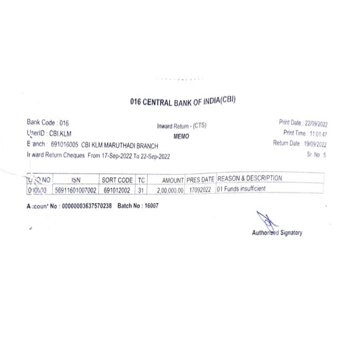

{'DocVQA': 'return v.mo'}


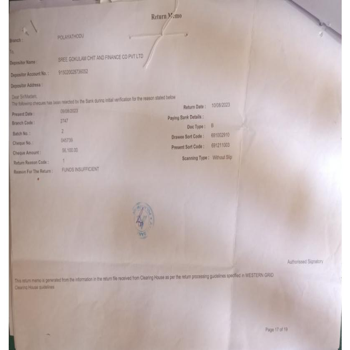

{'DocVQA': 'return menu report'}


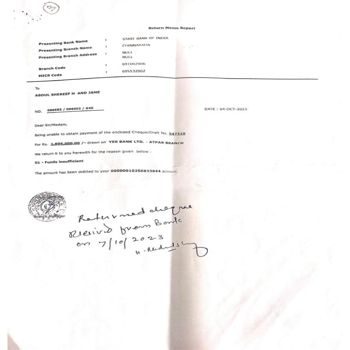

In [11]:
for idx in range(3):
  print(run_example("DocVQA", 'What do you see in this image?', data['train'][idx]['image']))
  display(data['train'][idx]['image'].resize([350, 350]))

We need to construct our dataset. Note how we are adding a new task prefix `<DocVQA>` before the question when constructing the prompt.

In [12]:
from torch.utils.data import Dataset

class DocVQADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<DocVQA>" + example['ques2']
        first_answer = example['ans2'][0]
        image = example['image']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return question, first_answer, image


Let's get to fine-tuning. We will create our dataset, the data collator, and start training. In A100 with 40GB memory, we can fit in 6 examples. If you're training on T4, you can use batch size of 1.

In [13]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (AdamW, AutoProcessor, get_scheduler)

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

# Create datasets
train_dataset = DocVQADataset(data['train'])
val_dataset = DocVQADataset(data['validation'])

# Create DataLoader
batch_size = 6
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

In [14]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, answers = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)


After training, we will push the model to Hugging Face Hub. To do so, we need to login first with write access. Make sure to pass either write token or fine-grained token (by first creating the repository and setting up fine-grained token access).

In [1]:
from huggingface_hub import notebook_login

notebook_login()

We will freeze image encoder for this tutorial. The authors have reported improvement in unfreezing image encoder, but note that this will result in more resource usage.

In [15]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

In [16]:
train_model(train_loader, val_loader, model, processor, epochs=2)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/2: 100%|██████████| 5/5 [01:59<00:00, 23.91s/it]


Average Training Loss: 1.7375018358230592


Validation Epoch 1/2: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Average Validation Loss: 1.6603732109069824


Training Epoch 2/2: 100%|██████████| 5/5 [01:55<00:00, 23.09s/it]


Average Training Loss: 0.9181946873664856


Validation Epoch 2/2: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


Average Validation Loss: 1.3490132093429565


You can push the model like below. You can find the fully fine-tuned DocVQA model [here](https://huggingface.co/HuggingFaceM4/Florence-2-DocVQA). You can find the demo [here](https://huggingface.co/spaces/andito/Florence-2-DocVQA).

Read more about Florence-2 and fine-tuning it [here](https://huggingface.co/blog/finetune-florence2).

In [4]:
model.push_to_hub("Sarvesh2003/florence_ft_1")
processor.push_to_hub("Sarvesh2003/florence_ft_1")

model.safetensors:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Sarvesh2003/florence_ft_1/commit/86b39adb0995d14179dc4400e863563e039b9a36', commit_message='Upload processor', commit_description='', oid='86b39adb0995d14179dc4400e863563e039b9a36', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# For davit error change the config file to the actual model config file from on which the model is based on

In [5]:
# Load model directly
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained("/teamspace/studios/this_studio/model_checkpoints/epoch_2")

AssertionError: only DaViT is supported for now

In [22]:
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model and processor
model_path = "model_checkpoints/epoch_2"
model = AutoModelForCausalLM.from_pretrained(model_path)
processor = AutoProcessor.from_pretrained(model_path)

# Set the model to evaluation mode
model.eval()

def process_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")

    # Prepare the question
    question = "What is the date present in the provided document?"

    # Prepare the input
    inputs = processor(text=question, images=image, return_tensors="pt").to(device)

    # Generate the output
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            num_beams=5,
            early_stopping=True
        )

    # Decode the output
    generated_text = processor.decode(outputs[0], skip_special_tokens=True)

    return generated_text

# Test the model on a new image
test_image_path = "/teamspace/studios/this_studio/memo.jpeg"  # Replace with the path to your test image
result = process_image(test_image_path)
print("Model output:", result)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Model output: 20


In [20]:
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import os

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model and processor
model_path = "model_checkpoints/epoch_2"
model = AutoModelForCausalLM.from_pretrained(model_path)
processor = AutoProcessor.from_pretrained(model_path)

# Set the model to evaluation mode
model.eval()

def process_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")

    # Prepare the question
    question = "What is the date present in the provided document?"

    # Prepare the input
    inputs = processor(text=question, images=image, return_tensors="pt").to(device)

    # Generate the output
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            num_beams=5,
            early_stopping=True
        )

    # Decode the output
    generated_text = processor.decode(outputs[0], skip_special_tokens=True)

    return generated_text

# Specify the directory containing your images
image_directory = "/teamspace/studios/this_studio/images"  # Replace with your image directory path

# Process all images in the directory
for filename in sorted(os.listdir(image_directory)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        image_path = os.path.join(image_directory, filename)
        result = process_image(image_path)
        print(f"Image: {filename}")
        print(f"Model output: {result}")
        print("---")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Image: image_1.jpg
Model output: unanswerable
---
Image: image_10.jpg
Model output: unanswerable
---
Image: image_11.jpg
Model output: 21/03/2019
---
Image: image_12.jpg
Model output: unanswerable
---
Image: image_13.jpg
Model output: 1
---
Image: image_14.jpg
Model output: 1
---
Image: image_15.jpg
Model output: unanswerable
---
Image: image_16.jpg
Model output: unanswerable
---
Image: image_17.jpg
Model output: unanswerable
---
Image: image_18.jpg
Model output: 07/10/2023
---
Image: image_19.jpg
Model output: unanswerable
---
Image: image_2.jpg
Model output: unanswerable
---
Image: image_20.jpg
Model output: unanswerable
---
Image: image_21.jpg
Model output: unanswerable
---
Image: image_22.jpg
Model output: unanswerable
---
Image: image_23.jpg
Model output: unanswerable
---
Image: image_24.jpg
Model output: 17/09/22
---
Image: image_25.jpg
Model output: 21/03/2019
---
Image: image_26.jpg
Model output: unanswerable
---
Image: image_27.jpg
Model output: unanswerable
---
Image: image_2

In [23]:
# Load model directly
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

In [24]:
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model and processor
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

# Set the model to evaluation mode
model.eval()

def process_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")

    # Prepare the question
    question = "What is the date present in the provided document?"

    # Prepare the input
    inputs = processor(text=question, images=image, return_tensors="pt").to(device)

    # Generate the output
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            num_beams=5,
            early_stopping=True
        )

    # Decode the output
    generated_text = processor.decode(outputs[0], skip_special_tokens=True)

    return generated_text

# Test the model on a new image
test_image_path = "/teamspace/studios/this_studio/memo.jpeg"  # Replace with the path to your test image
result = process_image(test_image_path)
print("Model output:", result)

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Model output: 025 SYNDICATE BANK(SYB)Bank Code: 025Inward Return - (CTS)Print Date: 16/09/2016User ID: synPrint Time: 17:24:18MEMOBranch: 4000203038 VILE PARLE EAST, MUMBAIReturn Date : 16/06/2016Invard Return Cheques As On 16-Sep-2016Page No: 80CHQ NOISORT CODE TCAMOUNT
